Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset - Done
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

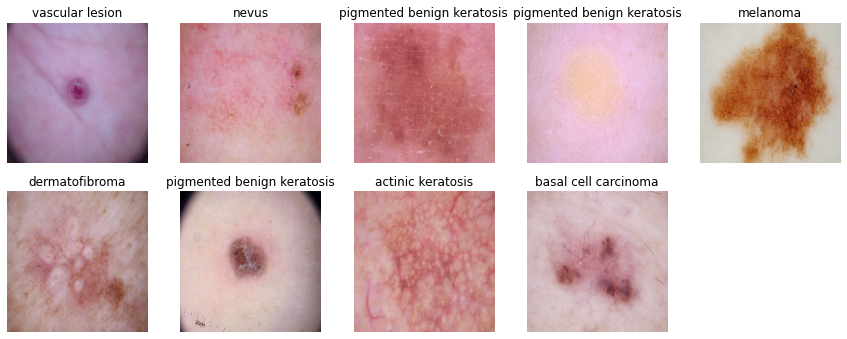

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
num_classes = len(class_names)
plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
num_classes = len(class_names)
img_rows, img_cols = 180, 180
input_shape = (img_rows, img_cols, 3)
print(num_classes)

9


In [12]:
### Your code goes here

#model
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255,
                 input_shape=input_shape))
# first conv layer
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected

# softmax layer
model.add(Dense(num_classes, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 298ms/step - loss: 1.9849 - accuracy: 0.2589 - val_loss: 1.7593 - val_accuracy: 0.3535
Epoch 2/20
56/56 [==============================] - 14s 256ms/step - loss: 1.6972 - accuracy: 0.3811 - val_loss: 1.5769 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 14s 256ms/step - loss: 1.6615 - accuracy: 0.4001 - val_loss: 1.7098 - val_accuracy: 0.4094
Epoch 4/20
56/56 [==============================] - 14s 257ms/step - loss: 1.4947 - accuracy: 0.4632 - val_loss: 1.4880 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 15s 259ms/step - loss: 1.4136 - accuracy: 0.5061 - val_loss: 1.3716 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 15s 261ms/step - loss: 1.3787 - accuracy: 0.5173 - val_loss: 1.3881 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 15s 261ms/step - loss: 1.2395 - accuracy: 0.5614 - val_loss: 1.5674 - val_accuracy: 0.4855

### Visualizing training results

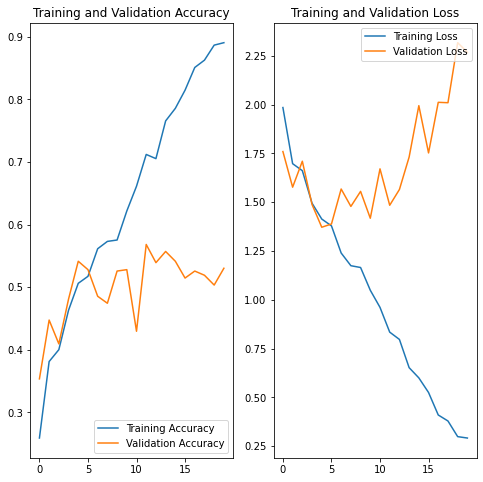

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

It's clear from the above data that the training accuracy is 89.06% and validation accuracy is 53.02%,
Training loss is 0.2915 and validation loss is 2.2682 after 20 epochs

If you see the graph 
1. Training accuracy is linearly increasing where as validation accuracy stalls around 53%.
2. Also, the difference in accuracy between training and validation accuracy is noticeable
3. Training loss is decreasing whereas validation loss is increasing
So this is clearly model overfit.

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

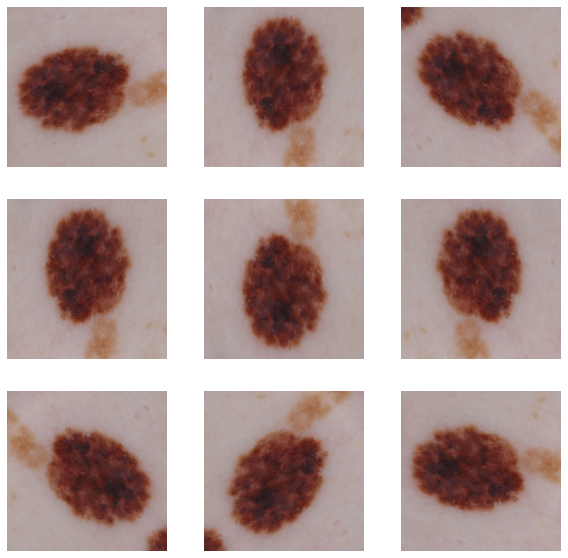

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
#model
model = Sequential()
#data augmentation
model.add(keras.layers.InputLayer(input_shape))
model.add(data_augmentation)
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255))
# first conv layer
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected

# softmax layer
model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 64)       

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 18s 303ms/step - loss: 2.0845 - accuracy: 0.2360 - val_loss: 1.8986 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 17s 311ms/step - loss: 1.7906 - accuracy: 0.3410 - val_loss: 1.7440 - val_accuracy: 0.3982
Epoch 3/20
56/56 [==============================] - 17s 300ms/step - loss: 1.6423 - accuracy: 0.4169 - val_loss: 1.5344 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 18s 313ms/step - loss: 1.5154 - accuracy: 0.4715 - val_loss: 1.4669 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 19s 332ms/step - loss: 1.5226 - accuracy: 0.4492 - val_loss: 1.5096 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 18s 330ms/step - loss: 1.4436 - accuracy: 0.4978 - val_loss: 1.5448 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 19s 331ms/step - loss: 1.3994 - accuracy: 0.4989 - val_loss: 1.4274 - val_accuracy: 0.4966

### Visualizing the results

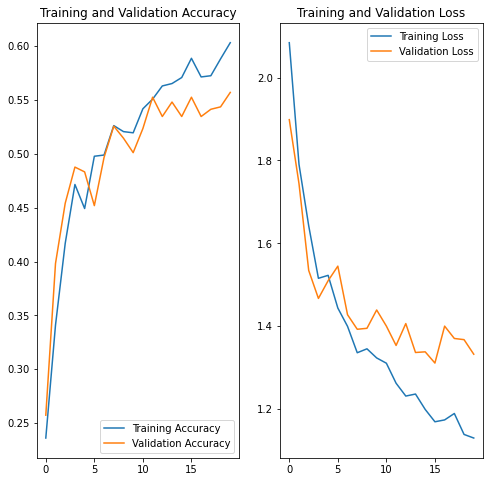

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

It's clear from the above data that the training accuracy is 60.32% and validation accuracy is 55.70%,
Training loss is 1.1296 and validation loss is 1.3321 after 20 epochs

If you see the graph 
1. Training accuracy is linearly increasing where as validation accuracy also linearly increasing.
2. Also, the difference in accuracy between training and validation accuracy is low
3. Training loss is decreasing whereas validation loss is also decreasing

There is some improvement now as compared to the previous model run.

The problem here is low training accuracy i.e., 60.32%
This is a case of model underfit with low variance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.
for class_name in class_names:
    name_count = 0
    for name in glob.glob('{0}/{1}/*'.format(data_dir_train,class_name)):
        name_count = name_count+1
    print(class_name + '-' + str(name_count))   

actinic keratosis-114
basal cell carcinoma-376
dermatofibroma-95
melanoma-438
nevus-357
pigmented benign keratosis-462
seborrheic keratosis-77
squamous cell carcinoma-181
vascular lesion-139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis has the least number of samples(77).

#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis(462 - 20.63%), melanoma(438 - 19.56%) and basal cell carcinoma(376 - 16.79%) dominate the data.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    path = str(path_to_training_dataset) + "/" + str(i)
    p = Augmentor.Pipeline(path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE21A710F40>: 100%|██████████| 500/500 [00:03<00:00, 129.67 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE2B91BF580>:   4%|▍         | 19/500 [00:00<01:01,  7.76 Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE21A6B2A00>: 100%|██████████| 500/500 [00:04<00:00, 107.46 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE2199D2EB0>:   2%|▏         | 11/500 [00:00<01:22,  5.96 Samples/s]                 

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE2B9446460>: 100%|██████████| 500/500 [00:05<00:00, 93.25 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FE2199ED1F0>: 100%|██████████| 500/500 [00:25<00:00, 19.48 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7FE21A712A30>: 100%|██████████| 500/500 [00:24<00:00, 20.74 Samples/s]  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE2199EDE80>:   2%|▏         | 11/500 [00:00<00:38, 12.64 Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE2191967C0>: 100%|██████████| 500/500 [00:04<00:00, 103.64 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE2199F0550>: 100%|██████████| 500/500 [00:11<00:00, 43.47 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE2B9E15250>: 100%|██████████| 500/500 [00:05<00:00, 97.78 Samples/s]                   
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE218CF3EB0>:   3%|▎         | 15/500 [00:00<01:09,  7.02 Samples/s]                  

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE238C8B1C0>: 100%|██████████| 500/500 [00:04<00:00, 103.86 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010872.jpg_d212ab8f-8991-4e0f-a1d0-6310589aea2b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000417.jpg_36170730-89e5-4ece-b1e0-155fbd69042a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010516.jpg_7761a8f1-cb48-4439-9e6d-b69009e9d489.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010772.jpg_cdf94a9a-6015-4524-bb5f-9b5fec3d5740.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010081.jpg_4b067c94-8f8e-48b2-a860-02da971d6348.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010514.jpg_f78af028-882c-4cbb-b8cc-76fa810cb172.jpg',
 'Skin cancer IS

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
##new_df = original_df.append(df2)

In [32]:
df2['Label'].value_counts()

basal cell carcinoma          500
squamous cell carcinoma       500
nevus                         500
melanoma                      500
actinic keratosis             500
dermatofibroma                500
vascular lesion               500
pigmented benign keratosis    500
seborrheic keratosis          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
data_dir_train=pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size) 

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
## your code goes here
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255,
                 input_shape=input_shape))
# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model.add(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [38]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 92s 540ms/step - loss: 2.0539 - accuracy: 0.2214 - val_loss: 1.7145 - val_accuracy: 0.3363
Epoch 2/30
169/169 [==============================] - 94s 551ms/step - loss: 1.4818 - accuracy: 0.4345 - val_loss: 1.3330 - val_accuracy: 0.4981
Epoch 3/30
169/169 [==============================] - 96s 564ms/step - loss: 1.3194 - accuracy: 0.5098 - val_loss: 1.2135 - val_accuracy: 0.5375
Epoch 4/30
169/169 [==============================] - 92s 542ms/step - loss: 1.1372 - accuracy: 0.5853 - val_loss: 1.1062 - val_accuracy: 0.6021
Epoch 5/30
169/169 [==============================] - 92s 543ms/step - loss: 0.9448 - accuracy: 0.6549 - val_loss: 0.9753 - val_accuracy: 0.6466
Epoch 6/30
169/169 [==============================] - 93s 544ms/step - loss: 0.7892 - accuracy: 0.7105 - val_loss: 1.1119 - val_accuracy: 0.6013
Epoch 7/30
169/169 [==============================] - 94s 550ms/step - loss: 0.7453 - accuracy: 0.7328 - val_loss: 0.8221 - val_ac

#### **Todo:**  Visualize the model results

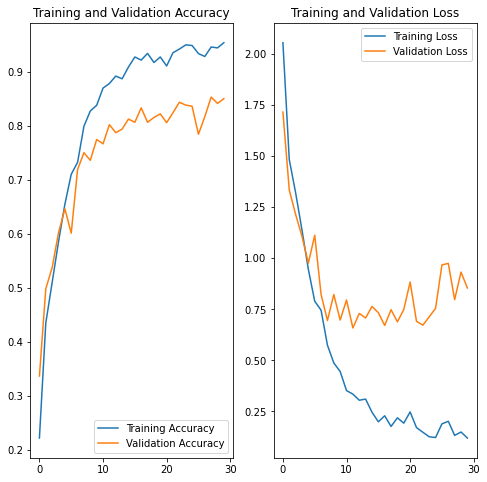

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



It's clear from the above data that the training accuracy is 95.46% and validation accuracy is 85.08%,
Training loss is 0.1199 and validation loss is 0.853 after 30 epochs

If you see the graph 
1. Training accuracy is linearly increasing where as validation accuracy also linearly increasing.
2. Also, the difference in accuracy between training and validation accuracy is low and both values are also good.
3. Training loss is decreasing whereas validation loss is also decreasing

We got rid of model overfitting/underfitting now as compared to the previous 2 models.

Class reimbalance helped here.